<a href="https://colab.research.google.com/github/ThiagoMonica/imersao-dados-desafio-final/blob/main/Desafio_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Projeto - Drug Discovery

Esse projeto é resultado de 5 aulas da Imersão Dados 3 da Alura. Nele, podemos ver algumas análises com base em um conjunto de dados oferecidos pelo [Kaggle](https://www.kaggle.com/c/lish-moa/overview/description). Essas análises levaram à construção de modelos de machine learning que nos auxiliriaram a atingir nossos objetivos.

### Objetivos
Através de modelos de machine learning, temos dois objetivos:

- Prever se uma configuração de experimento pode ativar 2 ou mais MOA's.
- Prever se no experimento foi ou não utilizado o composto com mais aplicações em todo o conjunto.

Assim, podemos cada vez mais automatizar alguns processos na extensa e delicada função que é a descoberta de novas drogas.

###Importação de Libs e carregamento de dados


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Leitura dos dados a partir do arquivo .zip
dados = pd.read_csv('https://github.com/ThiagoMonica/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true', compression = 'zip')

#Leitura dos resultados
dados_resultados = pd.read_csv('https://github.com/ThiagoMonica/imersao-dados-desafio-final/blob/main/Dados/dados_resultados.csv?raw=true')

#Rename da coluna droga para composto
mapa = {'droga':'composto'}
dados.rename(columns=mapa, inplace=True)

###Conhecendo os dados

Os dados dizem respeito à 23.814 experimentos em diferentes **culturas de células** que foram submetias à algum algum composto.

Abaixo temos o que significa cada coluna dos nossos dados:

*   id: identificador do experimento. Esse valor é único, portanto ele não se repete na base de dados.


*   tratamento: diz qual o tratamento utilizado nos experimentos. Pode assumir dois valores:

  * com_droga: a cultura celular foi submitida à um determinado **composto** (explicitado na coluna *composto*).

  * com_controle: a cultura celular foi submitida à um tipo **placebo**. Esse tipo de experimento não altera nenhuma característica do experimento e existe para ser utilizado como parâmetro de comparação para outros experimentos.

Tratamento   | Quantidade
-------------|------------
com_droga    | 21948
com_controle | 1866


*   tempo: representa o tempo em horas que a cultura celular ficou exposta ao composto. Pode assumir 24, 48 ou 72.
 
Tempo | Quantidade
------|------------
24    | 7772
48    | 8250
72    | 7792


*   dose: representa a dose do composto que o experimento foi observado. Pode assumir D1 (1ª dose) ou D2 (2ª dose).

Dose | Quantidade
-----|------------
D1   | 12147
D2   | 11667


*  composto: representa o composto em que a cultura celular foi exposto. Pode-se observar que não trabalhamos com os nomes reais dos compostos, mas sim nomes fictícios.

*   g-x: representa a expressão genética do gene x. Isso significa que, dada a exposição de um composto em uma cultura celular, um a expressão genética de uma célula pode aumentar, aumentando também a produção de determinada proteína, ou pode diminuir, causando o efeito contrário na produção de proteínas da célula. Nesta base, temos 0 a 771 genes.

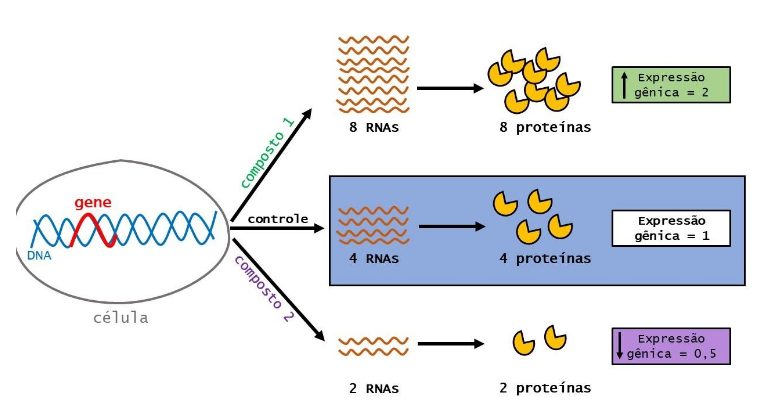

*   c-x: representa a viabilidade genética, ou seja, quantas células sobreviveram ou não à aplicação do composto. Temos 0 a 99 viabilidades celular na base de dados.




In [ ]:
dados.head()

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


Nossa base *dados_resultados* contém os resultados dos experimentos da tabela *dados*. Nela podemos ver a coluna id, que mantém o mesmo valor dos experimentos da tabela dados, e o restante das colunas que representam os resultados no formato binário (1 se ativa ou 0 se não ativa) para cada *Mechanism of Action* (MOA) dos experimentos. Cada MOA contém uma proteína e um tipo de ação do MOA que age nesta proteína separados por um "_" (*underline*) no nome da coluna, no formato *proteína_tipo-de-ação-do-moa*. Esse tipo de ação do MOA pode ser um inibidor (dado composto inibe a produção de tal proteína), ativador (dado composto ativa a produção de tal proteína), entre outros.

Abaixo podemos ver os tipos de ações dos MOAs existentes nos nossos resultados.

In [ ]:
#Retira a coluna id e soma os MOAs, obtendo a quantidade de MOAs ativados
contagem_moa = dados_resultados.drop('id', axis=1).sum().sort_values(ascending = False)

#Separa cada coluna no "_" e pega a última posição
tipos_moa = [classe.split('_')[-1] for classe in contagem_moa.index]

#Cria um df com cada último nome (tipo de ação do MOA) e sua quantidade na linha
count_moa = pd.DataFrame({'Tipo_MOA':tipos_moa, 'Count':contagem_moa.values})

#Agrupa por nome e soma as quantidades
moas = count_moa.groupby('Tipo_MOA').sum()['Count'].sort_values(ascending = False)
moas

Tipo_MOA
inhibitor            9693
antagonist           3449
agonist              2330
blocker               323
agent                 150
activator             115
local                  80
immunosuppressant      73
anti-inflammatory      73
antioxidant            73
medium                 56
sensitizer             51
stimulant              49
antibiotic             43
antiprotozoal          36
antifolate             36
secretagogue           30
donor                  26
b                      26
antiviral              23
antimalarial           18
scavenger              18
antifungal             13
antihistamine          12
analgesic              12
anticonvulsant         12
antiarrhythmic          6
diuretic                6
laxative                6
steroid                 6
Name: Count, dtype: int64

Podemos ver os 10 MOA's mais utilizados nos experimentos

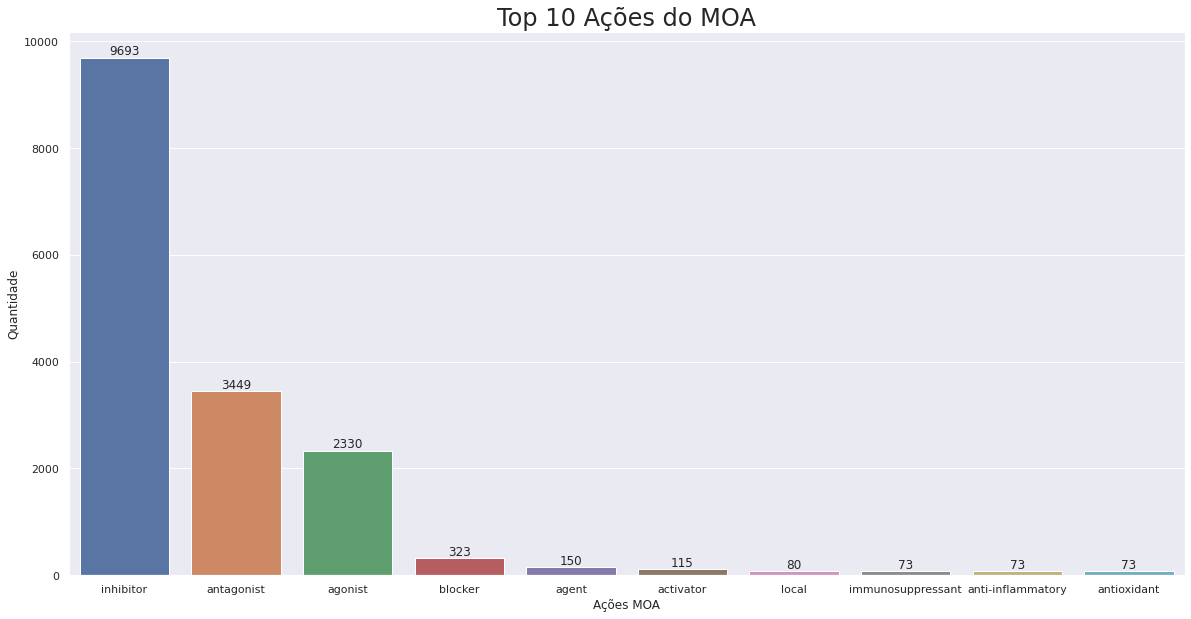

In [ ]:
sns.set()

plt.figure(figsize=(20,10))
#Seleciona os 10 primeiros moa's
ax = sns.barplot(x = moas[:10].index, y = moas[:10].values)
                  
ax.set_title('Top 10 Ações do MOA', fontsize=24)
ax.set(xlabel='Ações MOA', ylabel='Quantidade')

#Gera a quantidade para barra no gráfico
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:1.0f}'.format(y),(x.mean(),y), 
            ha='center', va='bottom') 

#Plota o gráfico
plt.show()

###Analisando os Dados

Para saber com o que estamos lidandos, vamos olhar detalhadamente o que temos no nosso conjunto de dados.

####Estudando os tipos de tratamentos
Analisando o conjunto de dados de tratamento, pode-se observar que há uma significante diferença entre seus tipos.

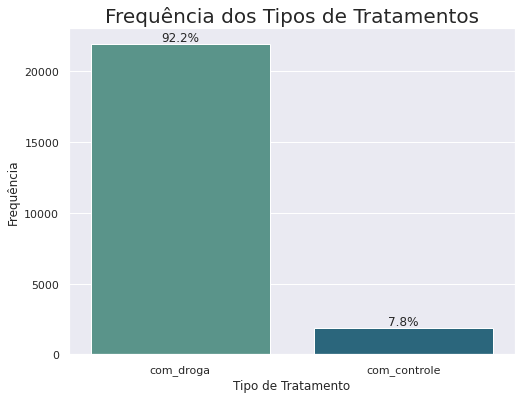

In [ ]:
#Inicia o seaborn
sns.set()

plt.figure(figsize=(8,6))
ax = sns.countplot(x = 'tratamento', 
                   data=dados, 
                   palette='crest')
ax.set_title('Frequência dos Tipos de Tratamentos', fontsize=20)
ax.set(xlabel='Tipo de Tratamento', ylabel='Frequência')

#Gera a porcentagem para cada composto no gráfico
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/(len(dados))), (x.mean(), y), 
            ha='center', va='bottom') 

#Plota o gráfico
plt.show()

Menos de 8% dos tratamentos foram feitos com controle. Por que existe essa diferença?

Para responder a essa pergunta, temos que olhar nossos dados mais de perto.

In [ ]:
#Filtrar apenas experimentos realizados com controle
dados_tratamento = dados[dados['tratamento']=='com_controle']
dados_tratamento.head()

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
25,id_0054388ec,com_controle,48,D1,cacb2b860,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,0.7785,0.7062,-0.7951,1.3770,0.2856,-0.8331,0.3879,1.3290,-0.4746,0.0857,-0.2745,-0.1093,0.2603,0.7386,-0.6665,-1.6520,-0.9262,0.0000,1.6310,-0.2933,0.2043,-2.2070,0.1383,-0.4966,0.6922,-0.4077,0.2303,-0.0456,-0.7447,...,0.6976,-0.0178,0.3768,0.4318,-0.1051,0.3933,-0.3189,0.4128,-0.2116,-1.0410,0.7798,0.1579,1.7250,1.4490,0.9117,-0.0754,-0.8396,0.7640,1.2080,1.1890,0.2114,0.6335,0.3265,-0.1056,0.5478,0.7477,1.2340,0.5035,-0.6591,0.3023,0.6171,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050
38,id_0079af0fb,com_controle,24,D1,cacb2b860,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,0.3856,-0.1670,-0.5400,0.2721,-0.2479,0.0761,-0.4054,2.9760,-0.7679,0.6995,0.0752,0.5943,0.4266,0.0000,1.0410,-0.1131,0.6593,-0.6890,0.5115,-0.2512,-0.8775,-1.3810,0.1419,-0.0363,0.2559,2.5290,0.2853,1.4690,-0.3626,...,-0.3420,0.2815,-0.7493,-0.2701,0.1205,0.2396,0.3506,-0.9233,0.2490,-0.0824,0.4841,1.1940,-1.1650,-0.4853,1.1080,-0.5979,0.7438,0.2050,-0.2761,-0.1748,0.3385,-0.3500,-0.0309,-0.0409,-0.0735,0.2732,-1.2100,0.0089,0.0317,0.4721,-0.3880,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820
40,id_007bfbb91,com_controle,24,D2,cacb2b860,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,0.3829,-1.8700,-0.0324,2.7670,-0.0438,-0.0147,0.1276,0.2968,-0.0704,-0.3767,2.5790,0.4069,-0.3868,-0.2782,1.8180,-2.9390,-0.1150,-0.8009,-1.4440,0.5412,-0.0804,-0.4444,2.9230,2.8270,-0.3437,1.6570,-1.9200,0.3442,1.7160,...,0.4009,0.7649,0.2789,0.4465,0.9492,0.6385,1.5510,-0.1220,0.6688,0.4396,0.6947,0.9761,1.2430,1.4770,-0.0081,1.0040,1.4420,-0.3482,0.3297,1.2070,0.0524,0.5346,0.7643,0.4067,0.3817,0.4566,0.7736,0.5316,0.2790,0.9735,0.7412,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180
47,id_008a986b7,com_controle,48,D2,cacb2b860,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,0.6459,-0.0109,1.0120,-0.0864,-0.3817,-1.0600,0.9435,0.6296,0.3864,0.1420,0.9834,0.4189,0.7980,-0.2132,0.7651,-1.2410,0.0747,-1.5750,0.1535,-0.0840,0.6705,-0.7517,-0.2756,-1.0920,-0.8683,0.3021,-0.3164,-0.2074,0.4587,...,-0.2189,-0.5262,-0.2982,-0.2491,-0.6373,-1.0040,-0.6726,-0.0321,-0.5398,-0.7518,0.0370,0.7213,-0.3466,0.2354,-0.4432,-0.1020,-0.9391,-1.1970,0.1365,-0.9264,0.5828,-0.7379,-0.4354,0.6077,-0.3771,-0.6525,-0.4169,-1.0640,-0.3331,-0.5761,-0.3085,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367
63,id_009d8340f,com_controle,24,D2,cacb2b860,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,-0.1187,1.1610,0.5838,-0.2996,-0.3995,1.0700,0.2969,-0.2785,0.9678,-0.1409,1.0850,-0.0656,-0.6502,0.3527,0.1998,0.0975,0.0563,-0.3578,-0.0657,0.5316,0.6573,-0.5355,1.2380,-0.4994,-0.8140,0.2567,-0.8155,1.1180,-0.2501,...,0.2427,0.5214,0.0587,-0.5903,0.1332,-0.3517,-0.3276,-0.4955,0.1359,-0.3010,0.5725,-0.1126,-0.0874,1.2220,-0.0641,0.0246,-0.5659,-0.7402,1.1170,-0.0612,-1.3040,-0.4025,0.3760,-0.0873,0.8064,-0.0170,0.3092,0.2671,0.3311,-0.4572,0.4795,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364


Nessa amostra pode-se perceber que a droga aplicada nesse tipo de experimento é a mesma. É possível confirmar isso com o agrupamento dos valores da classe composto.

In [ ]:
dados_tratamento['composto'].unique()

array(['cacb2b860'], dtype=object)

Aqui temos como resultado que em todos os experimentos realizados com o tratamento com controle foi utilizado o composto ***cacb2b860***. Com isso, podemos concluir que a droga citada acima é um **tipo placebo** usada de apoio aos outros experimentos no qual o fator testado é aplicado. 

Então é condizente afirmar que a diferença das frequências do tipo tratamento ocorre pois **é mais significativo fazer o experimento em casos em que o fator testado é aplicado** do que em placebos.

####Visualizando os compostos mais utilizados
Para conhecer melhor nossos dados, podemos olhar mais de perto uma das classes mais relevantes para o projeto: compostos.

O composto é o ponto de partida de cada experimento. É a partir dele que todas as mudanças começam a aparecer e agregar nos nossos conhecimentos dos experimentos.

Abaixo vemos os 5 compostos mais utilizados nos experimentos.

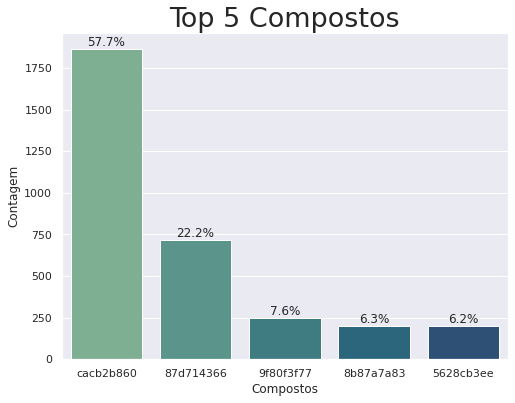

In [ ]:
#Captura dos 5 compostos mais frequentes através do index
cod_compostos = dados['composto'].value_counts().index[:5]

#Cria dados filtrados
tops_compostos = dados.query('composto in @cod_compostos')

#Inicia o seaborn
sns.set()

plt.figure(figsize=(8,6))
ax = sns.countplot(x = 'composto', 
                   data=tops_compostos, 
                   order=tops_compostos['composto'].value_counts().index, 
                   palette='crest')
ax.set_title('Top 5 Compostos', fontsize=27)
ax.set(xlabel='Compostos', ylabel='Contagem')

#Gera a porcentagem para cada composto no gráfico
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/(len(tops_compostos))), (x.mean(), y), 
            ha='center', va='bottom') 

#Plota o gráfico
plt.show()

Como vimos anteriormente, o composto ***cacb2b860*** representa um placebo, logo ele não influência nos resultados dos experimentos.

Podemos ver os 5 compostos mais utilizados e que não são placebos para conhecer aqueles que afetam as células de alguma maneira.

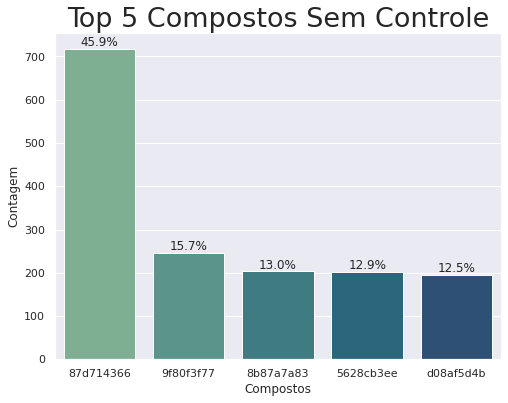

In [ ]:
#Captura dos 5 compostos mais frequentes através do index eliminando o primeiro composto
cod_compostos = dados['composto'].value_counts().index[1:6]

#Cria dados filtrados
tops_compostos = dados.query('composto in @cod_compostos')

#Inicia o seaborn
sns.set()

plt.figure(figsize=(8,6))
ax = sns.countplot(x = 'composto', 
                   data=tops_compostos, 
                   order=tops_compostos['composto'].value_counts().index, 
                   palette='crest')
ax.set_title('Top 5 Compostos Sem Controle', fontsize=27)
ax.set(xlabel='Compostos', ylabel='Contagem')

#Gera a porcentagem para cada composto no gráfico
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/(len(tops_compostos))), (x.mean(), y), 
            ha='center', va='bottom') 

#Plota o gráfico
plt.show()

####Conhecendo o comportamento dos genes (g-x) e da viabilidade celular (c-x)

Para conhecer um pouco mais das expressões dos genes do conjunto, podemos fazer uso do histograma. 

Analisaremos a classe g-19.

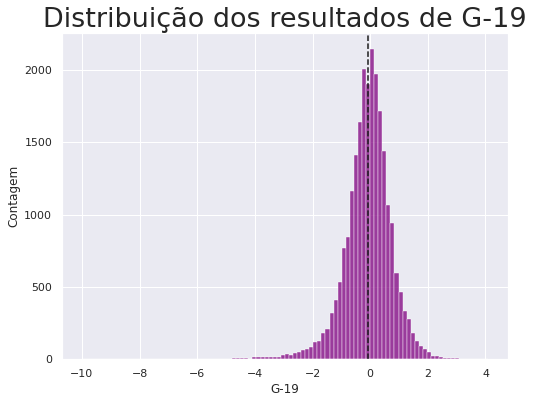

In [ ]:
sns.set()
plt.figure(figsize=(8,6))

#Geração do histograma
ax = sns.histplot(data=dados, x='g-19', bins=100, color='purple')
ax.set_title('Distribuição dos resultados de G-19',fontsize=27)

#Gera linha da média
plt.axvline(x=dados['g-19'].mean(), linestyle="--", color='k') 

ax.set(xlabel='G-19', ylabel='Contagem')

plt.show()

Podemos ver que o gene g-19 possui, aparentemente, uma distribuição parecida com a normal.

O uso do boxplot também se faz interessante nesse caso.

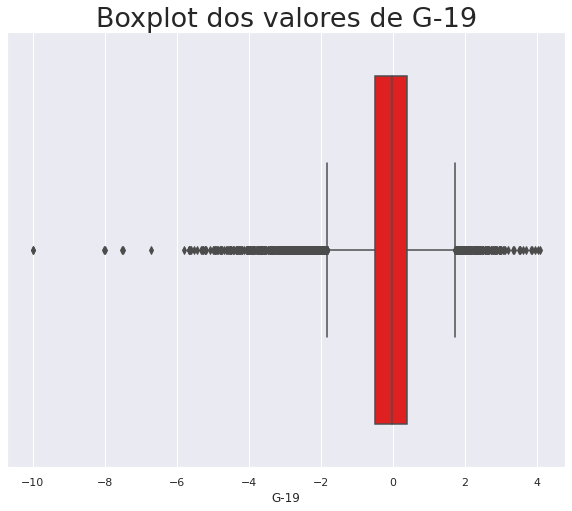

In [ ]:
plt.figure(figsize=(10,8))

ax = sns.boxplot(x='g-19', data=dados, color='red')

ax.set_title('Boxplot dos valores de G-19',fontsize=27)
ax.set(xlabel='G-19')

plt.show()

Com o boxplot podemos ver que, apesar de seguir uma distribuição próxima da normal, há um número significante de *outliers*.

Outliers podem ser entendidos como valores que diferem drasticamente dos outros, ou seja, são pontos fora da curva.

Para ter uma visão ampla desse gene, podemos utilizar a classe describe().

A função *describe()* retorna as principais estatísticas sobre os dados. São eles:

*   *Count* - Quantidade de dados da classe

*   *Mean* - Mostra o valor médio da classe (Média)

*   *std* - Indica o quanto o conjunto de dados é uniforme (desvio padrão)

*   *min* - Menor valor da classe (Minínmo)

*   *25%* - Quando ordenados em ordem crescente, o primeiro quartil deixa 25% das observações abaixo e 75% acima.


*   *50%* - Quando ordenados em ordem crescente, o segundo quartil divide o conjunto em duas partes iguais (Mediana)

*   *75%* - Quando ordenados em ordem crescente, o terceiro quartil deixa 75% das observações abaixo e 25% acima.

*   *max* - Maior valor da classe (Máximo)

In [ ]:
dados['g-19'].describe()

count    23814.000000
mean        -0.082982
std          0.844796
min        -10.000000
25%         -0.488675
50%         -0.027800
75%          0.400600
max          4.081000
Name: g-19, dtype: float64

Podemos utilizar essa mesma função para visualizar o comportamento de todos os genes do nosso conjunto de dados.

In [ ]:
#Descreve as classes de g-0 a g-771
dados.loc[:,'g-0':'g-771'].describe()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,g-732,g-733,g-734,g-735,g-736,g-737,g-738,g-739,g-740,g-741,g-742,g-743,g-744,g-745,g-746,g-747,g-748,g-749,g-750,g-751,g-752,g-753,g-754,g-755,g-756,g-757,g-758,g-759,g-760,g-761,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,0.119905,-0.123321,0.182307,0.143203,0.209402,-0.173884,-0.024432,0.126823,-0.146663,0.087687,-0.082982,-0.111908,-0.087379,0.047548,-0.117474,-0.113212,-0.052746,-0.091055,0.112176,-0.046458,-0.076239,-0.197699,0.382177,-0.189432,0.078791,-0.093312,0.135729,-0.188616,-0.606710,0.534425,0.132026,...,0.263569,-0.242638,0.110180,-0.039868,-0.064056,0.193629,0.004470,-0.187085,0.067186,0.006159,-0.201189,-0.243317,0.548903,0.247065,0.085950,0.090544,0.215525,-0.007705,0.236954,0.022785,0.103224,0.048402,0.109367,-0.103262,0.004129,0.066211,0.072773,-0.033051,-0.400643,-0.338978,0.207299,0.009161,0.171027,0.002316,-0.209799,-0.076251,0.134162,-0.128018,-0.219210,0.101524
std,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,1.087180,1.291501,1.253604,1.234590,1.273068,1.247178,0.659839,1.418997,1.179688,0.743301,0.844796,1.219529,0.824401,0.924838,0.760159,1.203186,0.866977,1.103765,1.001687,1.027758,1.279399,1.302567,1.559174,0.933514,1.172270,1.174325,1.061719,1.397677,2.200277,2.003317,0.990477,...,1.075809,1.309482,0.881283,0.917119,1.186966,1.212621,1.175611,1.182180,1.057292,0.996940,1.029370,1.378815,2.023791,1.639307,1.238753,0.961212,1.293783,0.966213,1.284074,1.015557,1.035968,1.048645,0.856080,1.175372,0.701031,0.996914,1.077310,1.579948,1.913468,1.701554,1.096488,1.200395,1.357701,1.052771,1.201918,1.115477,0.951264,1.230636,1.326193,1.417674
min,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,-8.337000,-10.000000,-5.870000,-8.587000,-5.018000,-10.000000,-10.000000,-10.000000,-10.000000,-4.226000,-10.000000,-10.000000,-5.700000,-10.000000,-10.000000,-10.000000,-8.272000,-8.184000,-4.835000,-7.913000,-10.000000,-10.000000,-2.956000,-8.356000,-7.182000,-10.000000,-9.261000,-10.000000,-10.000000,-10.000000,-4.223000,...,-5.504000,-10.000000,-3.790000,-10.000000,-10.000000,-10.000000,-7.920000,-10.000000,-9.462000,-6.634000,-10.000000,-10.000000,-2.912000,-9.833000,-7.227000,-5.561000,-8.393000,-5.790000,-4.915000,-10.000000,-10.000000,-7.918000,-5.255000,-10.000000,-6.264000,-10.000000,-5.505000,-10.000000,-10.000000,-10.000000,-8.193000,-10.000000,-9.795000,-8.180000,-10.000000,-10.000000,-4.269000,-10.000000,-10.000000,-10.000000
25%,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,-0.360200,-0.511475,-0.489675,-0.447500,-0.481200,-0.607975,-0.404150,-0.391950

Uma forma interessante de analisar a classe a partir de suas estatísticas é transpor a tabela com describe(). Assim obtemos x=estatisticas e y=classes.

Para transpor a tabela de dados, utilizamos a função T.



```
df.T
```

In [ ]:
dados.loc[:,'g-0':'g-771'].describe().T

,count,mean,std,min,25%,50%,75%,max
g-0,23814.0,0.248366,1.393399,-5.513,-0.473075,-0.00885,0.525700,10.000
g-1,23814.0,-0.095684,0.812363,-5.737,-0.562200,-0.04660,0.403075,5.039
g-2,23814.0,0.152253,1.035731,-9.104,-0.437750,0.07520,0.663925,8.257
g-3,23814.0,0.081971,0.950012,-5.998,-0.429575,0.00805,0.463400,10.000
g-4,23814.0,0.057347,1.032091,-6.369,-0.470925,-0.02690,0.465375,10.000
...,...,...,...,...,...,...,...,...
g-767,23814.0,-0.076251,1.115477,-10.000,-0.506200,0.00990,0.511175,6.317
g-768,23814.0,0.134162,0.951264,-4.269,-0.353100,0.00540,0.409075,10.000
g-769,23814.0,-0.128018,1.230636,-10.000,-0.544600,0.00060,0.498500,5.911
g-770,23814.0,-0.219210,1.326193,-10.000,-0.554400,0.02870,0.496400,10.000


Aqui temos, por exemplo a média de todos os valores dos genes dos dados. Com issol, podemos observar sua distribuição no conjunto.

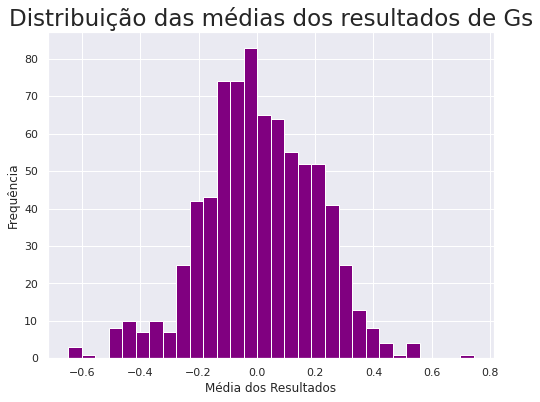

In [ ]:
plt.figure(figsize=(8,6))

#Filtra os dados com as classes Gs, transpõe e obtém as médias
ax = dados.loc[:,'g-0':'g-771'].describe().T['mean'].hist(bins = 30, color='purple')

ax.set_title('Distribuição das médias dos resultados de Gs',fontsize=23)
ax.set(xlabel='Média dos Resultados', ylabel='Frequência')

plt.show()

No gráfico acima podemos ver que os genes têm uma distribuicação de médias parecida com a normal.

Podemos fazer o mesmo para os menores valores de g's.

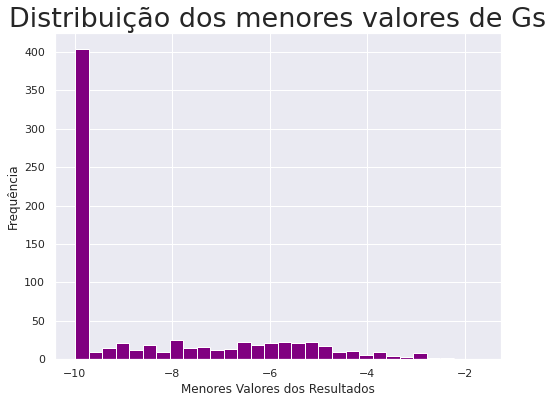

In [ ]:
plt.figure(figsize=(8,6))

#Filtra os dados com as classes Gs, transpõe e obtém o min
ax = dados.loc[:,'g-0':'g-771'].describe().T['min'].hist(bins = 30, color='purple')

ax.set_title('Distribuição dos menores valores de Gs',fontsize=27)
ax.set(xlabel='Menores Valores dos Resultados', ylabel='Frequência')

plt.show()

Aqui vemos que os menos valores de g's estão bem concentrados em -10

E para os seus maiores valores.

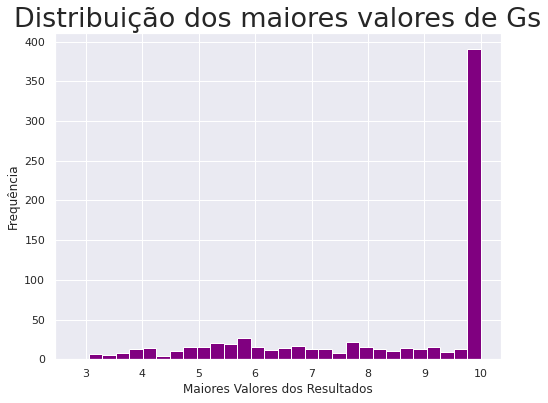

In [ ]:
plt.figure(figsize=(8,6))

#Filtra os dados com as classes Gs, transpõe e obtém o max
ax1 = dados.loc[:,'g-0':'g-771'].describe().T['max'].hist(bins = 30, color='purple')

ax1.set_title('Distribuição dos maiores valores de Gs',fontsize=27)
ax1.set(xlabel='Maiores Valores dos Resultados', ylabel='Frequência')

plt.show()

Aqui ocorre o caso inverso dos menores valores de g's. Nesse gráfico podemos ver que mais de 350 genes têm valor máximo igual a 10.

Analisando a distribuição de médias, mínimos e máximos dos genes das culturas celulares, podemos concluir que esses dados sofreram algum tipo de normalização, com mínimo em -10 e máximo em 10.

Podemos fazer o mesmo estudo com a classe de viabilidade celular.

Usaremos a classe c-14 como exemplo.

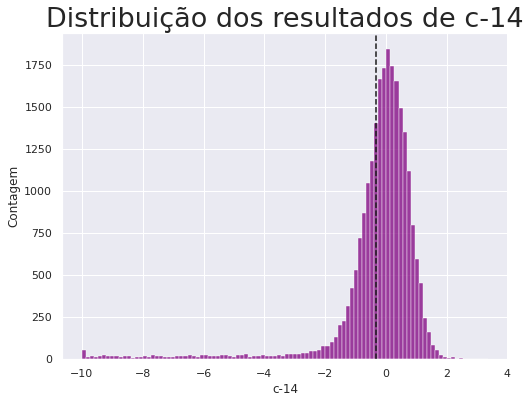

In [ ]:
sns.set()
plt.figure(figsize=(8,6))

#Geração do histograma
ax = sns.histplot(data=dados, x='c-14', bins=100, color='purple')
ax.set_title('Distribuição dos resultados de c-14',fontsize=27)

#Gera linha da média
plt.axvline(x=dados['c-14'].mean(), linestyle="--", color='k') 

ax.set(xlabel='c-14', ylabel='Contagem')

plt.show()

C-14 parece ter uma distribuição parecida com a normal.

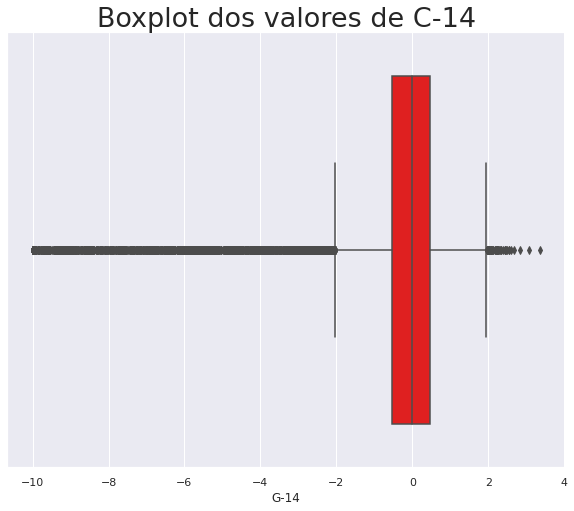

In [ ]:
plt.figure(figsize=(10,8))

ax = sns.boxplot(x='c-14', data=dados, color='red')

ax.set_title('Boxplot dos valores de C-14',fontsize=27)
ax.set(xlabel='G-14')

plt.show()

Neste gráfico, podemos perceber que há uma grande quantidade de outliers negativos nessa classe.

Agora analisando as viabilidades celulares como um todo.

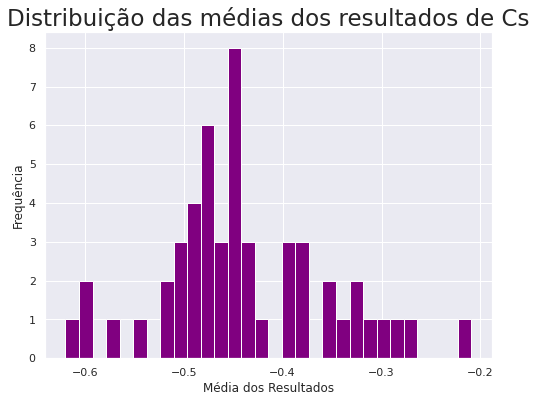

In [ ]:
plt.figure(figsize=(8,6))

#Filtra os dados com as classes Gs, transpõe e obtém as médias
ax = dados.loc[:,'c-0':'c-50'].describe().T['mean'].hist(bins = 30, color='purple')

ax.set_title('Distribuição das médias dos resultados de Cs',fontsize=23)
ax.set(xlabel='Média dos Resultados', ylabel='Frequência')

plt.show()

As médias das viabilidades celulares parecem ser bem dispersas, assumindo valores significamente distintos dentro do conjunto.

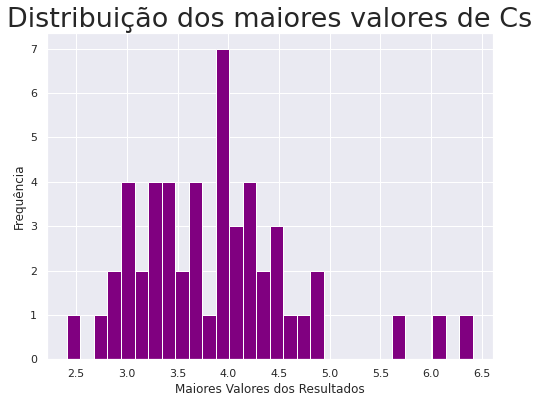

In [ ]:
plt.figure(figsize=(8,6))

#Filtra os dados com as classes Gs, transpõe e obtém o max
ax1 = dados.loc[:,'c-0':'c-50'].describe().T['max'].hist(bins = 30, color='purple')

ax1.set_title('Distribuição dos maiores valores de Cs',fontsize=27)
ax1.set(xlabel='Maiores Valores dos Resultados', ylabel='Frequência')

plt.show()

Essa diferença de valores também é refletido nos máximos valores de C.

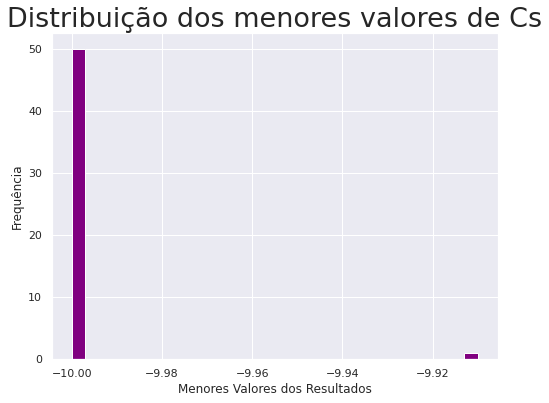

In [ ]:
plt.figure(figsize=(8,6))

#Filtra os dados com as classes Gs, transpõe e obtém o min
ax = dados.loc[:,'c-0':'c-50'].describe().T['min'].hist(bins = 30, color='purple')

ax.set_title('Distribuição dos menores valores de Cs',fontsize=27)
ax.set(xlabel='Menores Valores dos Resultados', ylabel='Frequência')

plt.show()

A disparidade de valores das médias e dos máximos, entretanto, não é reflextido nos mínimos valores do conjunto, nos quais quase todos assumem o valor de -10.

#####Correlação

Os gráficos de heatmaps nos ajudam a entender de forma mais visual e sumarizada os valores das classes.

Nesse caso, utilizamos os heatmaps para visualizar as correlações entre as diversas classes.

No gráfico abaixo podemos perceber que não há um padrão muito bem estabelecido entre as correlações das classes g-0 a g-50. Até pode-se perceber correlações um pouco mais altas entre algumas classes, mas isso não é refletido entre todo o grupo.

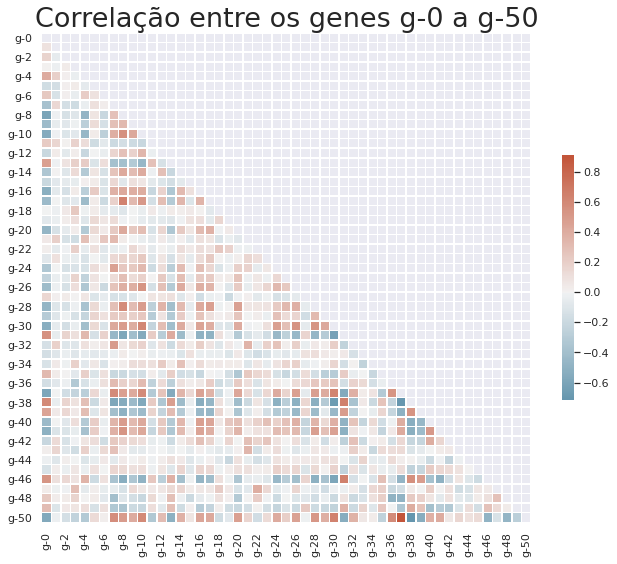

In [ ]:
# Compute the correlation matrix
corr = dados.loc[:,'g-0':'g-50'].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('Correlação entre os genes g-0 a g-50',fontsize=27)

plt.show()

Vendo o gráfico das correlações das classes c-0 a c-50, vemos que ele tem comportamento diferente das classes gs mostradas acima. Suas correlações são muito altas independentemente do intervalos.

Isso significa que a viabilidade celular (quantas celulas sobreviveram ou não à aplicação do composto) desses tipos de células são muito parecidos mesmo fazendo experimentos diferentes.

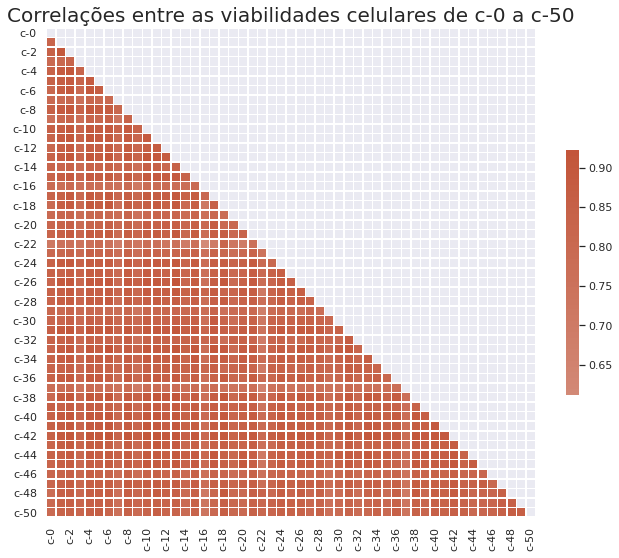

In [ ]:
#Aqui pegamos as correlações das classes c-0 a c-50 em todas as linhas do conjunto 
corr_celular = dados.loc[:,'c-0':'c-50'].corr()

#Cria uma mascara a partir uma matriz de true com o mesmo shape de corr_celular  
#e muda para false todos os valores abaixo da última posição de true comparando à coluna anterior (triângulo maior)
mask = np.triu(np.ones_like(corr_celular, dtype=bool))

#Redimensiona a figura
f, ax = plt.subplots(figsize=(11, 9))

#Cria uma paleta de cores divergente
cmap = sns.diverging_palette(230, 20, as_cmap=True)

#Desenha o heatmap aplicando a mascara e o cmap criado anteriormente
sns.heatmap(corr_celular, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('Correlações entre as viabilidades celulares de c-0 a c-50',fontsize=20)

plt.show()

Agora vamos observar a correlação entre os genes e as viabilidades celulares de 0 a 50.

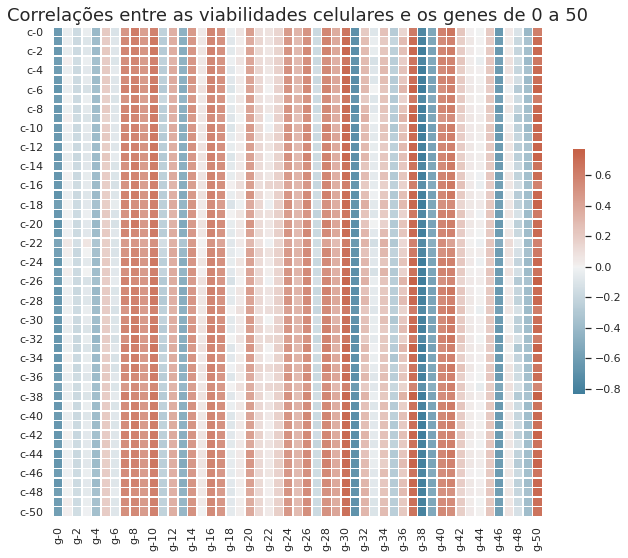

In [ ]:
#Filtra as classes Cs e Gs
viab_celular = dados.loc[:,'c-0':'c-50']
genes = dados.loc[:,'g-0':'g-50']

#Concatena nas colunas, calcula a correlação das classes e seleciona as linhas com C e colunas com G
dados_corr = pd.concat([viab_celular, genes], axis=1).corr().loc['c-0':'c-50','g-0':'g-50']

#Redimensiona a figura
f, ax = plt.subplots(figsize=(11, 9))

#Cria uma paleta de cores divergente
cmap = sns.diverging_palette(230, 20, as_cmap=True)

#Desenha o heatmap aplicando a mascara e o cmap criado anteriormente
sns.heatmap(dados_corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('Correlações entre as viabilidades celulares e os genes de 0 a 50',fontsize=18)

plt.show()

O gráfico acima nos dá algumas informações importantes. Como vimos no gráfico anterior, as viabilidades celulares estão com uma **alta correlação positiva**, então faz sentido vermos cada quadradinho com uma correlação bem próxima na mesma coluna. Além disso, podemos perceber muito mais colunas avermelhadas do que azuladas. Isso se deve a alta correlação positiva da maoiria dos casos estudos.

Biologicamente, esses fatos indicam que, possivelmente, quem está alterando de fato os resultados do experimento é o **gene**, isso pois as **viabilidades celulares se comportam de forma muito parecida entre elas**, então as mudanças dos experimentos podem ser reflexos das **mudanças dos genes**. 

Não só isso, mas também podemos ver nos experimentos que na maioria dos casos selecionados, por conta da maioria das correlações serem diretamente proporcionais, quando, ao aplicar um composto em determinada cultura celular, um gene se expressa mais, a viabilidade celular aumenta (morrem mais células).

Importante lembrar que isso são apenas indícios pois, via de regra, **correlação não implica causalidade.**

###Processamento dos dados

Nesta etapa, vamos modificar e criar alguns novos dados a fim de nos auxiliar à atingir o objetivo do projeto.

####Criação de uma coluna que diz quantos MOA's foram ativados

Criamos uma nova coluna *n_moa* com a quantidade de MOAs ativado no experimento. Usaremos isso para futuras análises

In [ ]:
dados_resultados['n_moa'] = dados_resultados.drop('id', axis=1).sum(axis=1)

####Ver se o experimento ativou algum MOA

Para realizar filtros facilmente, criamos a coluna *ativo_moa* que diz se o experimento ativou ou não algum MOA.

Fazemos isso verificando se *n_moa* na linha é diferente de 0.

In [ ]:
dados_resultados['n_moa'] != 0

0         True
1        False
2         True
3        False
4         True
         ...  
23809     True
23810     True
23811    False
23812     True
23813    False
Name: n_moa, Length: 23814, dtype: bool

In [ ]:
dados_resultados['ativo_moa'] = (dados_resultados['n_moa'] != 0)
dados_resultados.head()

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,n_moa,ativo_moa
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,True
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True


####Combinação dos experimentos e seus resultados

Agora que já temos nosso *dados_resultados* em um formato fácil para realizar estudos, temos de unir a nossa base de experimentos e resultados.

Um dos modos possíveis de unir diferentes tabelas é usando a função `df.merge()` do *pandas*. Esse método funciona de forma parecida com um *Join*  do SQL. Isso significa que a função recebe uma tabela (direita) como parâmetro, outra tabela (esquerda) para se fundir e em qual coluna deve ocorrer essa fusão (parâmetro `on`).

Não só isso, mas a função aplica também os diferentes *Joins* do SQL através do parâmetro `how`. Sendo eles:

*   Left: Usa apenas as chaves da tabela da esquerda.

*   Right: Usa apenas as chaves da tabela da direita.

*   Outer: Usa a união das chaves de ambas tabelas; Não preserva a ordem das chaves.
*   Inner (default): Usa a intersecção das chaves de ambas tabelas, ou seja, faz o cruzamento apenas em linhas que as chaves são iguais. Se não forem iguais, ele preserva a chave da tabela da esquerda.

*   Cross: Cria o produto cartesiano de ambas tabelas.

Outro método possível é o `df.join()` consegue combinar as colunas de duas tabelas com índices diferentes em apenas uma tabela resultante. Ela também recebe o parâmetro `on` que contém a coluna a ser alinhada.

A função `concatenate()` também combina as colunas a partir da concanetação das mesmas com tabelas de mesmo numero de linhas.

Uma função que explica e faz a visualização de duas tabelas diferente é a `compare()`. Ela permite comparar duas tabelas e sumarizar as diferenças.

Como temos o *id* como chave única (não se repete em nenhuma linha) em ambas tabela representando o mesmo experimento, podemos cruzar essas tabelas em valores de *id* iguais em ambas. 

Assim, temos mais poder de análise com os dados cruzados

In [ ]:
#Cruza as tabelas usando id e mantém apenas id, n_moa e ativo_moa da tabela dados_resultados
dados_combinados = pd.merge(dados, dados_resultados[['id','n_moa','ativo_moa']], on='id')
dados_combinados.head()

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,True
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,True


Aqui vemos que a coluna *ativo_moa* retornou `false` para todos os tratamentos com controle.

Com isso, podemos confirmar que os experimentos são coerentes dado que nenhum experimento controlado deveria ativar algum dos MOAs estudados.

In [ ]:
dados_combinados.query('tratamento == "com_controle"')['ativo_moa'].value_counts()

False    1866
Name: ativo_moa, dtype: int64

Já comparando os experimentos tratados com droga, vemos que quase 2/3 deles ativaram algum MOA.

In [ ]:
dados_combinados.query('tratamento == "com_droga"')['ativo_moa'].value_counts()

True     14447
False     7501
Name: ativo_moa, dtype: int64

####Criação de colunas dummies

Agora, para evitar filtragens e análises com strings, podemos criar uma coluna com valores binários de tratamento.

O mesmo é válido para o tempo, com a diferencça que criaremos três colunas (cada uma representando um tempo). A coluna que conter 1 dentre as três sinaliza o tempo do experimento. Ou seja, dentre elas, não pode haver mais de uma coluna com 1 e deve existir pelo menos um 1.

In [ ]:
dados_combinados['eh_controle'] = np.where(dados_combinados['tratamento'] == 'com_controle', 1, 0)
dados_combinados['24'] = np.where(dados_combinados['tempo'] == 24, 1, 0)
dados_combinados['48'] = np.where(dados_combinados['tempo'] == 48, 1, 0)
dados_combinados['72'] = np.where(dados_combinados['tempo'] == 72, 1, 0)

dados_combinados.head()

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa,eh_controle,24,48,72
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,True,0,1,0,0
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False,0,0,0,1
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True,0,0,1,0
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False,0,0,1,0
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,True,0,0,0,1


###Analises com os dados combinados

Agora temos nossos resultados juntamente com os dados dos experimentos, podemos fazer alguns estudos mais profundos do nosso novo conjunto de dados.

####Ver se os principais compostos ativaram algum MOA

Analisando o gráfico abaixo, podemos ver que 4 dos 5 compostos ativam algum MOA e o que restou é usado no tratamento com controle. É possível ver também que os compostos que ativaram algum MOA, tem os quartis bem distribuídos em g-0 e poucos *outliers*.

É possível observar também que os compostos *8b87a7a83* e *9f80f3f77*, mesmo tendo algum efeito no gene g-0, não resultou em uma mudança muito expressiva no mesmo de um modo geral.

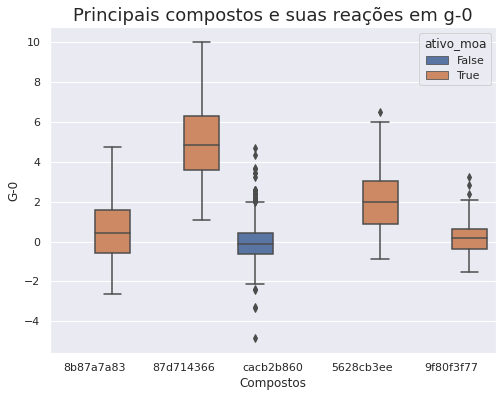

In [ ]:
composto_principal = dados_combinados['composto'].value_counts().index[:5]
plt.figure(figsize=(8,6))
ax = sns.boxplot(data=dados_combinados.query('composto in @composto_principal'), y='g-0', x='composto',hue='ativo_moa')

                  
ax.set_title('Principais compostos e suas reações em g-0', fontsize=18)
ax.set(xlabel='Compostos', ylabel='G-0')

#Plota o gráfico
plt.show()

####Analise de g-30

Podemos visualizar o comportamento do gene g-30 considerando o tempo de tramento e suas doses. Além disso, podemos comparar juntamente, por exemplo o efeito do composto **5628cb3ee** nesse gene e compará-lo com o tratamento controlado.

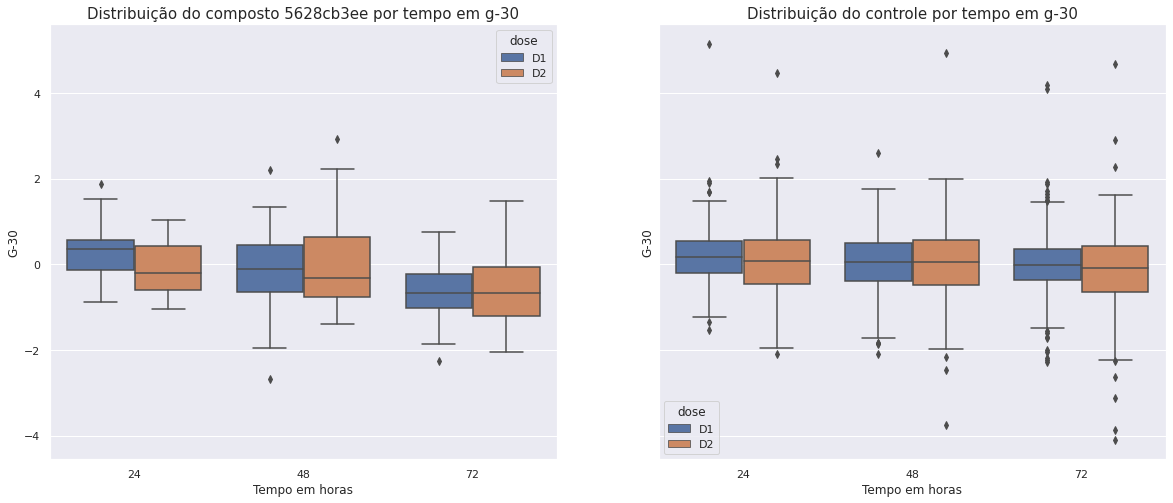

In [ ]:
#Seta plots em uma mesma linha e com a mesma escala usando sharey=True
fig, ax = plt.subplots(1,2,figsize=(20,8), sharey=True)

#Monta o boxplot considerando os experimentos do composto 5628cb3ee e comparando sua distribuição em g-30 por tempo, analisando tbm suas doses
sns.boxplot(data=dados_combinados.query('composto == "5628cb3ee"'), y='g-30', x='tempo', hue='dose', ax = ax[0])

#Set titles e labels
ax[0].set_title('Distribuição do composto 5628cb3ee por tempo em g-30', fontsize=15)
ax[0].set(xlabel='Tempo em horas', ylabel='G-30')

#Monta o boxplot considerando os experimentos de tratamento com controle e comparando sua distribuição em g-30 por tempo, analisando tbm suas doses
sns.boxplot(data=dados_combinados.query('eh_controle == 1'), y='g-30', x='tempo', hue='dose', ax = ax[1])

#Set titles e labels
ax[1].set_title('Distribuição do controle por tempo em g-30', fontsize=15)
ax[1].set(xlabel='Tempo em horas', ylabel='G-30')

#Plota o gráfico
plt.show()

Usando a distribuição do controle de g-30 como parâmetro, poodemos ver que a ação do composto 5628cb3ee em g-30, primeiramente reduziu a quantidade de outliers do conjuntos.

Podemos observar também que, ao longo do tempo de tratamento, o gene tende a se estabilizar independentemente da dose aplicada.

####Ativação de MOA

Um outro estudo possível também pode ser verificar se tem algum composto que dependendo da configuração do experimento, ativa ou não ativa algum MOA.

Aqui criamos duas lista de compostos: uma em que os MOAs foram ativados e outra em que não foram. Depois vimos se as listas tinham algum composto em comum.

O resultado foi 0, ou seja, nenhum experimento que ativou um moa deixou de ativar em outro experimento e vice-versa.

In [ ]:
ativados = dados_combinados.query('ativo_moa == True')['composto']
n_ativados = dados_combinados.query('ativo_moa == False')
n_ativados.query('composto in @ativados').shape[0]

0

####Ativação de diferentes MOAs

Nessa mesma linha, podemos ver se tem algum composto que dependendo da configuração do experimento, ativa um MOAs diferente.

Primeiramente, criamos uma tabela combinada com os resulados e o composto.

In [ ]:
dados_merge = dados[['id','composto']]
dados_combinados_merge = dados_resultados.drop(['n_moa','ativo_moa'],axis=1)

dados_combinados_resultados = pd.merge(dados_merge, dados_combinados_merge, on='id')
dados_combinados_resultados.head()

,id,composto,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,b68db1d53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,df89a8e5a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,18bb41b2c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,8c7f86626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,7cbed3131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Podemos criar uma função que analisa cada assinatura do experimento. Caso exista mais de uma assinatura igual, armazenamos em uma lista.

In [ ]:
def ve_assinatura(linhas_do_resultado):
# Resultado ainda será criado 
  assinaturas = linhas_do_resultado.iloc[:,2:].value_counts()
  lista = []
#Verificando se temos mais de uma assinatura para cada composto
  if len(assinaturas) > 1:
    lista.append(assinaturas)
  return lista

#Verificando a assinatura para cada composto
resultado = dados_combinados_resultados.groupby('composto').apply(ve_assinatura)

In [ ]:
for linha in resultado:
  if len(linha):
    print(linha)

Como o resultado veio vazio, podemos inferir que as configurações dos experimentos **não influenciam** nos MOAs pelos compostos.

###Machine Learning para prever resultados

Aqui operamos algumas técnicas de machine learning com Sci-kit learning para criar alguns modelos treinando e testando os mesmos para resolver alguns uns problemas.

####Regressão Logística

Regressão Logística é um algoritmo de Machine Learning usado para prever a probabilidade de uma variável receber determinada categoria. Neste algoritmo, a variável resultante é binária que pode receber 1 (sucesso) ou 0 (fracasso).

Nesse caso, queremos construir um modelo que possa prever se uma assinatura vai ou não ativar pelo menos um MOA.

In [ ]:
#Selecionamos apenas as assinaturas
x = dados_combinados.select_dtypes('float64')
y = dados_combinados['ativo_moa']

#Criamos subconjuntos para treino (80%) e teste (20%), mantendo a proporção de ativo_moa e congelando a aleatoriedade da distribuição
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

#Inicializamos o modelo com um máximo de 1000 iterações
modelo_rlogistica = LogisticRegression(max_iter=1000)

#Treinamos o modelo com as assinaturas e as respostas
modelo_rlogistica.fit(x_treino, y_treino)

#Testamos o modelo com as assinaturas e as respostas esperadas
modelo_rlogistica.score(x_teste, y_teste)

0.6267058576527399

O número acima significa que nosso modelo obteve uma porcentagem de acerto de 62.7%. Ou seja, 62.7% das vezes que a assinatura ativava ou não um MOA, nosso modelo acertava ao dizer que tal assinatura ativava ou não um MOA.

Para termos uma referência de qualidade dessa porcetagem, ou seja, se é uma boa quantidade de acerto ou não, podemos criar um modelo *dummy* que classifica todos com apenas um valor. Assim, temos um parâmetro de eficiência do nosso modelo. Se a porcentagem de acerto do modelo dummy for maior ou próxima do nosso modelo de regressão logística, significa que nosso modelo não foi muito eficiente.

In [ ]:
#Modelo dummy diz que todos n_moa são o valor mais frequente em n_moa do treino
modelo_dummy = DummyClassifier('most_frequent')

#Treina o modelo com as assinaturas e as respostas
modelo_dummy.fit(x_treino, y_treino)

#Preve as respostas para o conjunto de teste x
previsão_dummy = modelo_dummy.predict(x_teste)

#Ve a acurácia comparada com o conjunto de teste y
accuracy_score(y_teste, previsão_dummy) 

0.6067604450976275

Aqui podemos ver que ele acerta justamente todos as assinaturas que ativaram pelo menos um MOA que e erra as que não ativaram nenhum MOA.

In [ ]:
dados_combinados['ativo_moa'].value_counts(normalize=True)

Com os resultados obtidos, podemos concluir que a técnica de regressão logística não é muito eficiente para o problema dado que ele acertou 62.7% dos casos e o modelo dummy acertou 60.7%.

####Árvore de Decisão

Podemos usar outros métodos de *Machine Learning* para achar modelos melhores para responder nosso problema. Um exemplo é a **árvore de decisão**.

O algoritmo de árvore de decisão é um método de aprendizado supervisionado usado para classificação e regressão. Seu objetivo é criar um modelo que preve o valor de uma variável através de um aprendizado de nós de decisão inferidos dos dados. 


In [ ]:
#Import libs
from sklearn.tree import DecisionTreeClassifier

x = dados_combinados.select_dtypes('float64')
y = dados_combinados['ativo_moa']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

#Cria árvore com no máximo 3 niveis de profundidade
modelo_arvore = DecisionTreeClassifier(max_depth=3)

#Treina modelo
modelo_arvore.fit(x_treino, y_treino)

#Testa o modelo
modelo_arvore.score(x_teste, y_teste)

0.6105395758975436

Com a árvore de decisão, obtivemos 61% de eficiência, ainda pior que nosso modelo de regressão logística.

Podemos ver como foi a árvore resultante e o conteúdo de seus nós.

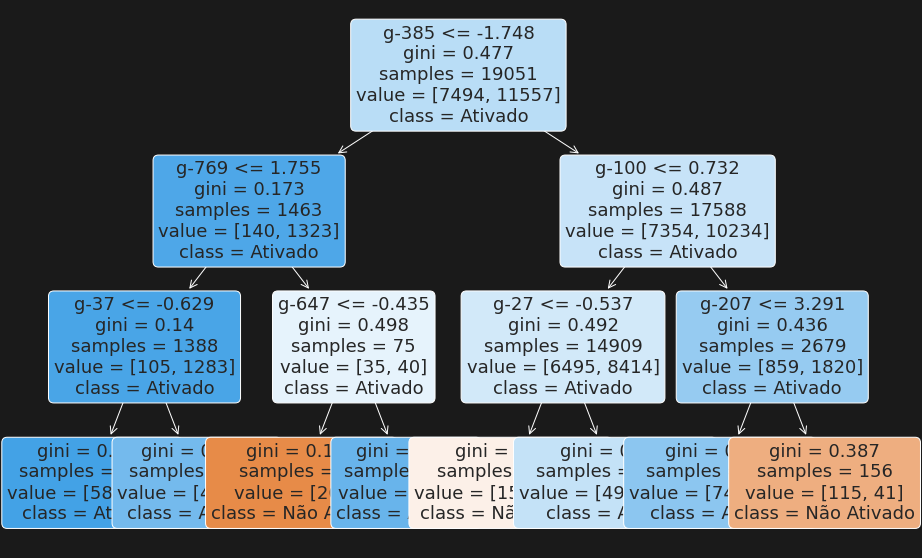

In [ ]:
#Define tamanho da imagem
fig, ax = plt.subplots(figsize=(15,10), facecolor='k')

#Plota a arvore
tree.plot_tree(modelo_arvore,
               ax=ax,
               fontsize=18,
               rounded=True,
               filled=True,
               feature_names=x_treino.columns,
               class_names=['Não Ativado', 'Ativado'])

plt.show()

Na árvore, vemos que o nó raiz de decisão foi constrúido a partir da classe g-385. Ou seja, se a assinatura possuir g-385 menor ou igual a -1.748 ele cai na filho à esquerda, caso contrário ele segue o caminho do filho à direita. Essa lógica é aplicada a todos os nós até chegar às folhas da árvore.

Aqui usamos novamente a árvore de decisão, porém com algumas diferenças:

- A amostra de teste representa 25% dos dados. Ou seja, nosso poder de treino diminuiu comparada com a outra árvore, mas há mais poder de teste.

- Máxima da profundidade é 5.

In [ ]:
x = dados_combinados.drop(['id', 'n_moa', 'ativo_moa','composto'], axis=1)
x = pd.get_dummies(x, columns=['tratamento','dose','tempo'])
y = dados_combinados['ativo_moa']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.25, stratify=y,random_state=900)

#Cria árvore com no máximo 3 niveis de profundidade
modelo_arvore = DecisionTreeClassifier(max_depth=5)

#Treina modelo
modelo_arvore.fit(x_treino, y_treino)

#Testa o modelo
modelo_arvore.score(x_teste, y_teste)

0.6884447430298959

Atingimos **68.8%** de eficiência. 7 pontos percentuais melhor que o outro modelo de árvore.

Podemos testar várias árvores de acordo com sua profundidade. Assim, conseguimos perceber se o modelo piora ou melhor ao mudar a profundidade.

In [ ]:
x = dados_combinados.select_dtypes('float64')
y = dados_combinados['ativo_moa']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

#Cria modelos com arvores de 1 a 15 nos de profundidade
teste=[]
treino=[]
for i in range(1,15):
  modelo_arvore = DecisionTreeClassifier(max_depth=i)
  modelo_arvore.fit(x_treino, y_treino)
  teste.append(modelo_arvore.score(x_teste, y_teste))
  treino.append(modelo_arvore.score(x_treino, y_treino))

In [ ]:
treino

[0.6066348223190384,
 0.6066348223190384,
 0.6211222508004829,
 0.6360820954280615,
 0.6412261823526324,
 0.6489423127394888,
 0.6605427536612252,
 0.6707259461445594,
 0.6895176106241142,
 0.7068395359823632,
 0.7294630203138943,
 0.7529788462547897,
 0.7770195790247231,
 0.7991706472101202]

In [ ]:
teste

[0.6067604450976275,
 0.6067604450976275,
 0.6105395758975436,
 0.6208272097417594,
 0.62019735460844,
 0.6180978374973756,
 0.6204073063195465,
 0.6210371614528658,
 0.6162082720974176,
 0.6138988032752467,
 0.6136888515641402,
 0.5979424732311568,
 0.5941633424312408,
 0.5996220869200084]

Os resultados obtidos mostram que o conjunto de treino melhora e o conjunto de testes piora de acordo com as profundidades. Quanto maior a profundidade, maior a quantidade de treino. Um possível problema de treinar muito é o *over-fitting*, no qual o modelo se especializa muito nos dados de treino e não consegue acertar entrada de dados gerais.

O gráfico mostra que o modelo sofreu um *overfit* ao longo dos treinamentos.

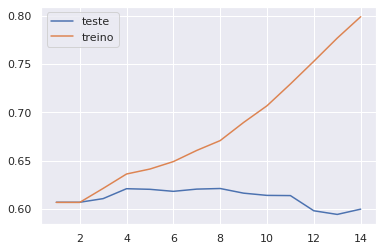

In [ ]:
sns.lineplot(x=range(1,15), y=teste, label='teste')
sns.lineplot(x=range(1,15), y=treino, label='treino')

plt.show()

####Random Forest

Outra técnica de *Machine Learning* é a **Random Forest**. Essa técnica estimadora que comporta um número de árvores de decisão em vários subconjusto dos dados e utilaza a média dos resultados para melhorar a preditividade e o controle de *over-fitting*.

Também utilizamos essa técnica para resolver nosso problema inicial.

In [ ]:
#Criamos os dados, todos contínuos com os dummies
x = dados_combinados.drop(['id', 'n_moa', 'ativo_moa','composto'], axis=1)
x = pd.get_dummies(x, columns=['tratamento','dose','tempo'])
y = dados_combinados['ativo_moa']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

#Treinamos e testamos o modelo
modelo_randomforest = RandomForestClassifier()
modelo_randomforest.fit(x_treino, y_treino)
modelo_randomforest.score(x_teste, y_teste)

0.6806634474070964

Com o resultado de 68% vemos que nenhuma das três técnicas consegue resolver de forma eficiente nosso problema.

####Perceptron
Podemos testar com outros modelos, como o Perceptron, com o qual atingimos **61.6%** de eficiência.

In [ ]:
x = dados_combinados.drop(['id', 'n_moa', 'ativo_moa','composto'], axis=1)
x = pd.get_dummies(x, columns=['tratamento','dose','tempo'])
y = dados_combinados['ativo_moa']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

modelo_perceptron = Perceptron()
modelo_perceptron.fit(x_treino, y_treino)
modelo_perceptron.score(x_teste, y_teste)

0.6105395758975436

####PassiveAggressive
Também foi testado um modelo *Passive Agressive*. Foi atingido 55% de eficiência, o que o trona pior que nosso modelo *dummy*.

In [ ]:
##Passivo Agressivo
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score

x = dados_combinados.drop(['id', 'n_moa', 'ativo_moa','composto'], axis=1)
x = pd.get_dummies(x, columns=['tratamento','dose','tempo'])
y = dados_combinados['ativo_moa']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

modelo_pass_agres = PassiveAggressiveClassifier()
modelo_pass_agres.fit(x_treino, y_treino)

#Preve as respostas para o conjunto de teste x
previsão_pass_agress = modelo_pass_agres.predict(x_teste)

#Ve a acurácia comparada com o conjunto de teste y
accuracy_score(y_teste, previsão_pass_agress) 

0.5723283644761705

###Uma assinatura pode ou não ativar pelo menos 2 MOAs?

Anteriormente, estavamos respondendo se uma determinada assinatura podia ativar ou não pelo menos um MOA. Podemos mudar nosso problema. Uma assinatura pode ou não ativar pelo menos 2 MOAs?

In [ ]:
#Nova coluna que sera target do nosso modelo
dados_combinados['ativo_moa_2'] = (dados_combinados['n_moa'] >= 2)
dados_combinados.head()

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa,eh_controle,24,48,72,ativo_moa_2
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,True,0,1,0,0,False
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False,0,0,0,1,False
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True,0,0,1,0,True
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False,0,0,1,0,False
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,True,0,0,0,1,False


Aqui usamos um modelo dummy para "chutar" todos os valores como o mais frequente na classe ativo_moa_2.

In [ ]:
dados_combinados['ativo_moa_2'].value_counts(normalize=True)

False    0.919585
True     0.080415
Name: ativo_moa_2, dtype: float64

Ou seja, fala que em todas as assinaturas nenhuma ativou pelo menos 2 MOAs. E obtemos um número alto: 92% de eficiência.

In [ ]:
x = dados_combinados.drop(['id', 'n_moa', 'ativo_moa','ativo_moa_2','composto'], axis=1)
x = pd.get_dummies(x, columns=['tratamento','dose','tempo'])
y = dados_combinados['ativo_moa_2']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

#Modelo dummy diz que todos n_moa são o valor mais frequente em n_moa do treino
modelo_dummy = DummyClassifier('most_frequent')

#Treina o modelo com as assinaturas e as respostas
modelo_dummy.fit(x_treino, y_treino)

#Preve as respostas para o conjunto de teste x
previsão_dummy = modelo_dummy.predict(x_teste)

#Ve a acurácia comparada com o conjunto de teste y
accuracy_score(y_teste, previsão_dummy) 

0.9195884946462314

Com a regressão logística, obtivemos 95% de eficiência.

In [ ]:
x = dados_combinados.drop(['id', 'n_moa', 'ativo_moa','ativo_moa_2','composto'], axis=1)
x = pd.get_dummies(x, columns=['tratamento','dose','tempo'])
y = dados_combinados['ativo_moa_2']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

#Inicializamos o modelo com um máximo de 1000 iterações
modelo_rlogistica = LogisticRegression(max_iter=1000)

#Treinamos o modelo com as assinaturas e as respostas
modelo_rlogistica.fit(x_treino, y_treino)

#Testamos o modelo com as assinaturas e as respostas esperadas
modelo_rlogistica.score(x_teste, y_teste)

0.9506613478899854

Com a árvore de decisão o resultado foi parecido: 95.1% de eficiência.

In [ ]:
x = dados_combinados.drop(['id', 'n_moa', 'ativo_moa','ativo_moa_2','composto'], axis=1)
x = pd.get_dummies(x, columns=['tratamento','dose','tempo'])
y = dados_combinados['ativo_moa_2']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

#Cria árvore com no máximo 5 niveis de profundidade
modelo_arvore = DecisionTreeClassifier(max_depth=5)

#Treina modelo
modelo_arvore.fit(x_treino, y_treino)

#Testa o modelo
modelo_arvore.score(x_teste, y_teste)

0.9515011547344111

Com esses resultados podemos concluir que prever se uma assinatura ativa ou não pelo menos 2 MOAs não é muito eficaz, dado que a distribuição é muito desigual (92% de assinaturas dos dados de treino assumem um mesmo valor). Logo, nossos modelos de machine learning não podem acrescentar grandes ganhos nesse quesito.

###Prever se o experimento foi feito com o composto mais utilizado

Suponhamos que perdemos alguns nomes de compostos nos laboratórios. Podemos usar machine learning para descobrir se determinado composto é o mais utilizado?

Sim, podemos!

Primeiro criamos a coluna que será o target do nosso modelo.

In [ ]:
top_composto = dados_combinados['composto'].value_counts().index[0]

dados_combinados[str(top_composto)] = (dados_combinados['composto'] == top_composto)
dados_combinados

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa,eh_controle,24,48,72,ativo_moa_2,cacb2b860
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,True,0,1,0,0,False,False
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False,0,0,0,1,False,False
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True,0,0,1,0,True,False
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False,0,0,1,0,False,False
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,True,0,0,0,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.6456,0.0136,-0.5141,-0.6320,0.7166,...,-0.2071,-0.6158,-0.2977,0.0992,0.6838,0.5259,0.7882,0.3119,-0.7697,0

Agora criamos nosso modelo dummy que supõe que todos os experimentos foram feitos com compostos diferentes de *cacb2b860*. E obtivemos 92.2% de eficiência. 

In [ ]:
x = dados_combinados.drop(['id', 'n_moa', 'ativo_moa','ativo_moa_2','composto','cacb2b860'], axis=1)
x = pd.get_dummies(x, columns=['tratamento','dose','tempo'])
y = dados_combinados['cacb2b860']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

#Modelo dummy diz que todos n_moa são o valor mais frequente em n_moa do treino
modelo_dummy = DummyClassifier('most_frequent')

#Treina o modelo com as assinaturas e as respostas
modelo_dummy.fit(x_treino, y_treino)

#Preve as respostas para o conjunto de teste x
previsão_dummy = modelo_dummy.predict(x_teste)

#Ve a acurácia comparada com o conjunto de teste y
accuracy_score(y_teste, previsão_dummy) 

0.9216880117572959

Com a regressão linear, obtivemos 100% de acerto.

In [ ]:
x = dados_combinados.drop(['id', 'n_moa', 'ativo_moa','ativo_moa_2','composto','cacb2b860'], axis=1)
x = pd.get_dummies(x, columns=['tratamento','dose','tempo'])
y = dados_combinados['cacb2b860']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

#Inicializamos o modelo com um máximo de 1000 iterações
modelo_rlogistica = LogisticRegression(max_iter=1000)

#Treinamos o modelo com as assinaturas e as respostas
modelo_rlogistica.fit(x_treino, y_treino)

#Testamos o modelo com as assinaturas e as respostas esperadas
modelo_rlogistica.score(x_teste, y_teste)

1.0

O mesmo aconteceu com a árvore de decisão.

In [ ]:
x = dados_combinados.drop(['id', 'n_moa', 'ativo_moa','ativo_moa_2','composto','cacb2b860'], axis=1)
x = pd.get_dummies(x, columns=['tratamento','dose','tempo'])
y = dados_combinados['cacb2b860']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, stratify=y,random_state=376)

#Cria árvore com no máximo 5 niveis de profundidade
modelo_arvore = DecisionTreeClassifier(max_depth=5)

#Treina modelo
modelo_arvore.fit(x_treino, y_treino)

#Testa o modelo
modelo_arvore.score(x_teste, y_teste)

1.0

Nesse caso, houve um raro caso em que os modelos conseguiram 100% de eficiência, ou seja, acertou, dentre todos os experimentos, se foi realizado com o composto *cacb2b860* ou não. E ainda apresentou ganhos comparado ao nosso modelo dummy.

###Conclusão

Após análisar os estudos aqui realizados e construir nossos modelos de previsão, foi possível observar que atingimos os objetivos pretendidos no começo do projeto com um score de 95% para a previsão de assinaturas que ativam 2 ou mais MOA's e 100% de score para prever se o experimento foi feito com o composto placebo cacb2b860.

###Agradecimentos

Gostaria de agradecer à toda equipe sensacional da Alura pela semana incrível de aprendizado, especialmente ao Thiago Gonçalves, Vanessa Leiko Oikawa Cardoso e Guilherme Silveira.

###Onde me encontrar

- [LinkeIn](https://www.linkedin.com/in/thiago-monica/)